# CNN + Grid-Search

# <font color = red> Road Map </font>
1. Preprocessing+EDA  --> Hyper paras
2. Tokenizer+Generate samples
3. Define CNN model         
4. Grid-Search for paras as follow:
        EMB =[30,50,100,150,200,300]
        NF =[16,24,32]
        FS = [(2,3,4,5),(1,2,3,4,5),(2,3,4,5,6), (1,2,3,4,5,6), (1,3,5,7),(2,4,6,8)]
        MDL= [MAX_DOC_LEN]
        MNW= [MAX_NB_WORDS]

        # EMBEDDING_DIM=200
        # CBOW_W2V = processor.w2v_pretrain(EMBEDDING_DIM) # 需要train, 比较慢
        # Glove_W2V = processor.load_glove_w2v(EMBEDDING_DIM) # 需要下载, 比较慢
        # PWV = [(CBOW_W2V),(Glove_W2V),(None)]

        PWV = [None]
        trainable_switch = [True]

        sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
        adam = optimizers.Adam(lr=1e-4)
        rmsprop = optimizers.RMSprop(lr=1e-4)
        optimizer = [sgd, 'SGD', rmsprop, 'RMSprop', 'Adagrad', 'Adadelta', adam, 'Adam', 'Adamax', 'Nadam']

5. Grid-Search Step by step
6. Evaluation
    - Accuracy

# import package

## Google colab

In [2]:
# !pip install tensorflow_gpu==1.15.0 
# !pip install nltk


# import os
# from google.colab import drive
# drive.mount('/content/drive')


# # import tensorflow.compat.v1 as tf
# # tf.disable_v2_behavior() 

import sys
# pypath = "/content/drive/My Drive/Colab Notebooks/CS584-Proj-improving/dataset"# Colab path
# sys.path.append(pypath)


In [3]:
from collections import Counter, defaultdict
from gensim.models import word2vec
# from IPython.core.interactiveshell import InteractiveShell
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.layers import Input, Dense, Activation, Embedding, Dropout, TimeDistributed
from tensorflow.keras.layers import Embedding, Dense, Conv1D, MaxPooling1D, Dropout, Activation, Input, Flatten, Concatenate, Lambda
from tensorflow.keras.layers import SimpleRNN, GRU, Bidirectional, LSTM
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
from matplotlib import pyplot as plt
from nltk import bigrams, trigrams, ngrams
from nltk.corpus import reuters, stopwords
from sklearn import preprocessing
# from tensorflow.keras.utils.vis_utils import model_to_dot, plot_model
from IPython.display import SVG
from numpy.random import seed
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import gensim.downloader as api
import glob
from tensorflow import keras
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import nltk, string
import numpy as np
import pandas as pd
import random
import re
import seaborn as sns
import string, os
import tensorflow as tf
import warnings
# InteractiveShell.ast_node_interactivity = "all"
# warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from myutils_V3 import eda_MAX_NB_WORDS, eda_MAX_DOC_LEN, text_preprocessor, cnn_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# tf.compat.v1.enable_eager_execution(config=None, device_policy=None, execution_mode=None)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)  # 关掉warning信息
import os

In [11]:
char_level_switch = False
symbols = ['nlpstart', 'nlpend' ]
MAX_NB_WORDS_ratio = 0.90
MAX_DOC_LEN_ratio = 0.95
nsamples=100000
test_ratio = 0.1
set_random=2

input_col = 'normalized_selected_text'
# input_col = 'normalized_text'
target_col = 'sentiment'


### load dataset
path =  "E:/OneDrive - stevens.edu/Stevens BIA/CS584/Proj/"
# path = "/content/drive/My Drive/Colab Notebooks/CS584-Proj-improving/dataset"# Colab path
# path =  "/Users/wy/OneDrive - stevens.edu/Stevens BIA/CS584/HW4/


### Save the result
saving_path = "./training/"
file_name = saving_path+'CNN_GS_V1' + input_col
if not os.path.exists(saving_path):
    os.mkdir(saving_path)

# Exploratory Data Analysis (EDA)
- Load target Dataset

In [12]:
%%time
wd = path+'dataset/data/'
# wd = "/kaggle/input/tweet-sentiment-extraction/"
filename = ['train.csv','test.csv']

Wall time: 0 ns


In [13]:
# train = pd.read_csv(wd+filename[0]).astype(str)
# test = pd.read_csv(wd+filename[1]).astype(str)
dt = pd.read_csv(wd+filename[0], nrows=nsamples).astype(str)

## Preprocess 
- deleted symbol other than ? and !

In [14]:
def normalize_string(s):
    s = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', s, flags=re.MULTILINE)  # deleted website
    s = re.sub(r'([!?])', r' \1', s) # separate those symbols as one word
    s = re.sub(r'[^a-zA-Z!?\d]+', r' ', s) # keep words, !?. and number
    s = re.sub(r'\s+', r' ', s) # drop other special symbol /t 
    return s
dt['normalized_text'] = [normalize_string(i) for i in dt["text"]]
dt['normalized_selected_text'] = [normalize_string(i) for i in dt["selected_text"]]
train, test = train_test_split(dt, test_size=test_ratio, shuffle=True, random_state=set_random)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24737 entries, 12750 to 23720
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   textID                    24737 non-null  object
 1   text                      24737 non-null  object
 2   selected_text             24737 non-null  object
 3   sentiment                 24737 non-null  object
 4   normalized_text           24737 non-null  object
 5   normalized_selected_text  24737 non-null  object
dtypes: object(6)
memory usage: 1.3+ MB


 ## Label encoding


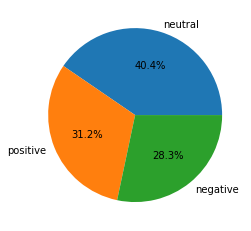

C:\Users\Administrator\Anaconda3\envs\py810\lib\site-packages\pandas\core\generic.py:6666: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regex=regex,


In [15]:
# Show the precentage = Balance dataset
nums = train['sentiment'].value_counts().values
labels = train['sentiment'].value_counts().keys()
plt.pie(x = nums, labels=labels,autopct='%1.1f%%')
plt.show()

replace_map = {'sentiment': {'neutral': 1, 'positive': 0, 'negative': 2}}
train.replace(replace_map, inplace=True)
test.replace(replace_map, inplace=True)

## Hyper pars

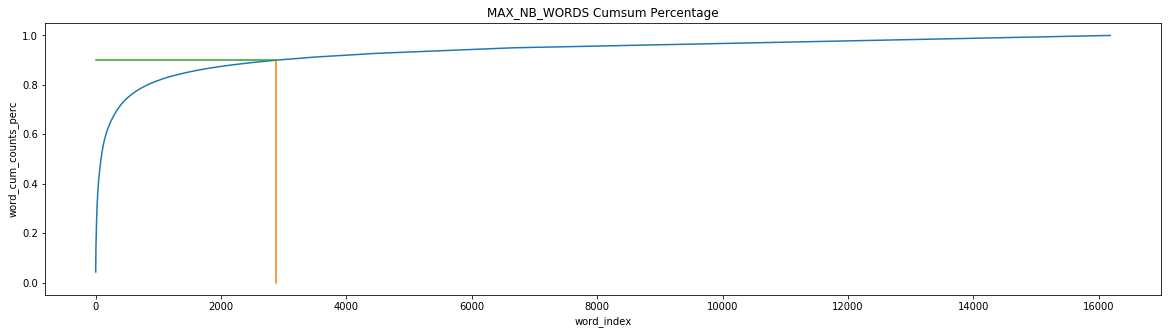

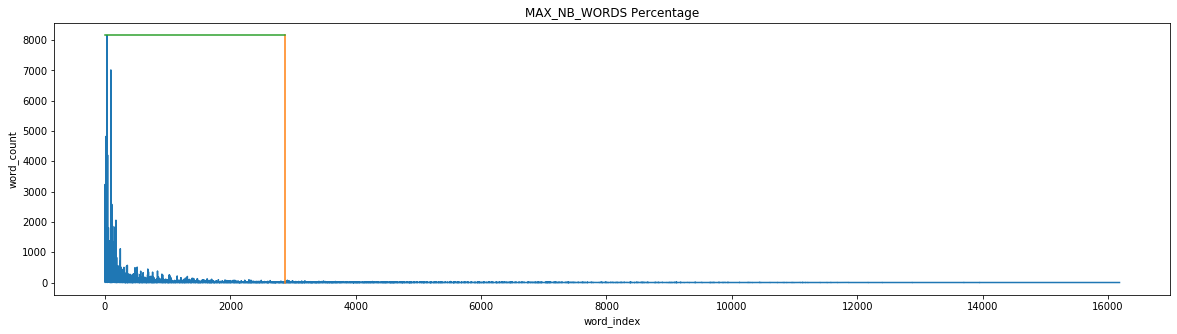

Cut index with 90.0 % of corpus:  2879 

    index  word  count
0      33     i   8157
1      94     !   7018
2      17    to   4824
3      42   the   4209
4       2     a   3237
5      16    it   2583
6     109   you   2582
7      19    my   2496
8     116   and   2158
9     175     ?   2057
10      8    is   1922
11    123     s   1859
12    157     t   1831
13     55    in   1812
14    100   for   1676
15     46    of   1494
16     48  that   1407
17     69    me   1381
18    120    on   1366
19     58    so   1293


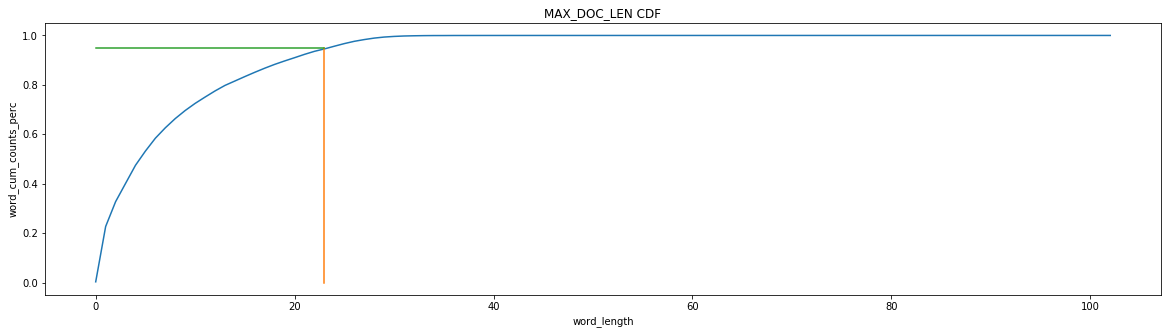

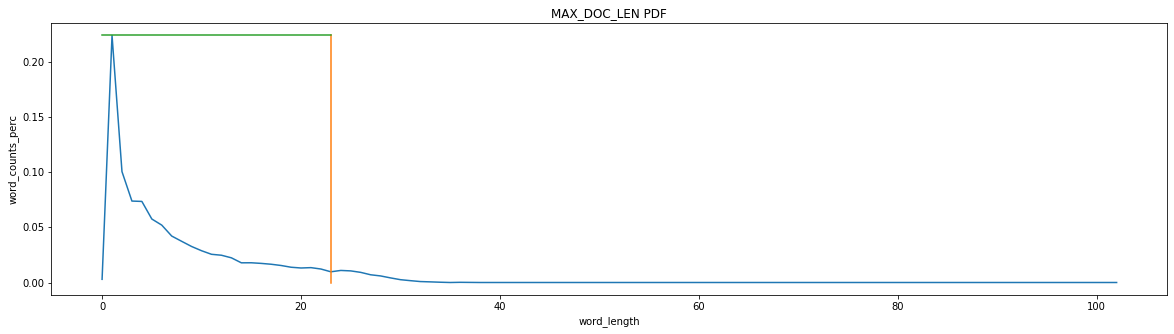

Cut index with 95.0 % of corpus:  23
Wall time: 1.57 s


In [16]:
%%time
corpus = train[input_col].astype(str).values
MAX_NB_WORDS = eda_MAX_NB_WORDS(corpus, ratio = MAX_NB_WORDS_ratio, filters='',char_level = char_level_switch)
MAX_DOC_LEN = eda_MAX_DOC_LEN(corpus, ratio = MAX_DOC_LEN_ratio, filters='',char_level = char_level_switch)

# initialize
processor = text_preprocessor(MAX_DOC_LEN, MAX_NB_WORDS, train[input_col])
MAX_NB_WORDS +=1 # for padding "0"

# Generate Data
- text_preprocessor Class defined in myutils
- Pretrained Embedding
    - PRETRAINED_WORD_VECTOR = embedding_matrix
    - EMBEDDING_DIM = 300

In [17]:
x_train = processor.generate_seq(train[input_col])
y_train = to_categorical(train[target_col])
x_test = processor.generate_seq(test[input_col])
y_test = to_categorical(test[target_col])
print('Shape of x_tr: ' + str(x_train.shape))
print('Shape of y_tr: ' + str(y_train.shape))
print('Shape of x_test: ' + str(x_test.shape))
print('Shape of y_test: ' + str(y_test.shape))

Shape of x_tr: (24737, 23)
Shape of y_tr: (24737, 3)
Shape of x_test: (2749, 23)
Shape of y_test: (2749, 3)


# Define Models

In [18]:
def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

def history_plot(training):
    
    ################## plot training history
#     dic = ['val_loss', 'loss', 'val_acc', 'acc', "val_auroc"] # print(training.history)
#     loss: 0.8109 - acc: 0.6362 - auroc: 0.7960 - val_loss: 0.6793 - val_acc: 0.7144 - val_auroc: 0.8684
    dic = list(training.history.keys())
#     idx = [[0,3],[1,4],[2,5]]
    idx = [[0,2],[1,3]]
    for i,j in idx:
        print("========================================================================")
        print(dic[i],dic[j])
        xx = list(range(1,len(training.history[dic[i]])+1))
        plt.plot(xx,training.history[dic[i]], color = 'navy', lw = 2, label = 'Model_'+str(dic[i]))
        plt.plot(xx,training.history[dic[j]], color = 'darkorange', lw = 2, label = 'Model_'+str(dic[j]))
        plt.title(str(dic[i]) + "v.s. training_" + str(dic[j]))
        plt.xlabel('Epochs')
        plt.ylabel(str(dic[i]))
        plt.legend()
        plt.show();
    return None

In [19]:
def train_model(model, x_train, y_train, x_test, y_test, BATCH_SIZE, NUM_EPOCHES, BestModel_Name="best_model", patience=10 ): # Final one step
    
    #### Best model selection 
    BEST_MODEL_FILEPATH = BestModel_Name
    earlyStopping = EarlyStopping(monitor='val_loss', patience=patience, verbose=1, mode='min') # patience: number of epochs with no improvement on monitor : val_loss
    # monitoring
    checkpoint = ModelCheckpoint(BEST_MODEL_FILEPATH, monitor='val_loss', verbose=0, save_best_only=True, mode='min')
    history = model.fit(x_train, y_train, validation_split=0.2, batch_size=BATCH_SIZE, epochs=NUM_EPOCHES, callbacks=[earlyStopping, checkpoint], verbose=2)
    model.load_weights(BestModel_Name)

    #### classification Report
    history_plot(history)
    y_pred = model.predict(x_test)
    print(classification_report(y_test, y_pred>0.5))
    scores = model.evaluate(x_test, y_test, verbose=2)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    print( "\n\n\n")
    return y_pred # 也许能出 tpr 和 fpr图

## CNN framework
- Feature Extraction: adjustable Multi-channel CNNs with different filter size
- Classfication
<img alt="cnn_base-1.png" src="./cnn_base-1.png">

## Dense for classification
<img src="./model_q2.png" >

In [20]:
# define Model for classification
def model_Create(FS, NF, EMB, MDL, MNW, PWV = None, optimizer='RMSprop', trainable_switch=True):
    cnn_box = cnn_model(FILTER_SIZES=FS, MAX_NB_WORDS=MNW, MAX_DOC_LEN=MDL, EMBEDDING_DIM=EMB, NUM_FILTERS=NF, PRETRAINED_WORD_VECTOR=PWV, trainable_switch=trainable_switch)
    q1_input = Input(shape=(MDL,), dtype='int32', name='q1_input') # Hyperparameters: MAX_DOC_LEN
    encode_input1 = cnn_box(q1_input)
    half_features = int(len(FS)*NF/2)
    dense1 = Dense(half_features,activation='relu', name='half_features')(encode_input1)
    drop_1 = Dropout(rate=0.4, name='dropout')(dense1)
    pred = Dense(3,activation='softmax', name='Prediction')(drop_1)
    
    model = Model(inputs=q1_input, outputs=pred)    
    model.compile(loss='categorical_crossentropy', optimizer= optimizer, metrics=['acc']) # estimator needs to provide a ``score`` function, 这里提供了准确对象
    return model

In [21]:
test.head()

,textID,text,selected_text,sentiment,normalized_text,normalized_selected_text
7723,a04c212559,"My boyfriend just broke his wrist, now he migh...",nervous,2,My boyfriend just broke his wrist now he might...,nervous
3303,650374fc21,"Yup, everything's there.","Yup, everything's there.",1,Yup everything s there,Yup everything s there
26959,5cc8486398,My graduation day... And i feel like a failure...,My graduation day... And i feel like a failure...,1,My graduation day And i feel like a failure,My graduation day And i feel like a failure
11539,b2167e666f,yo u can't love 1 twin and not the other lol,lol,0,yo u can t love 1 twin and not the other lol,lol
5982,d219b7f854,I'm having no luck either Doing my nut in! W...,no luck,2,I m having no luck either Doing my nut in ! W...,no luck


In [22]:
MAX_DOC_LEN

23

In [23]:
MAX_NB_WORDS

2880

# 3-fold Cross validation + Grid Search + Callbacks
- Only Earlystoping - monitoring accuracy (save max)
- Grid Search with keras.wrappers.scikit_learn
- <font color=red> Embedding dimension</font>

In [24]:
def Best_model_report(grid_result, to_file='GV_result.xlsx' ):
    GV_result = pd.DataFrame(grid_result.cv_results_)
    GV_result.to_excel(to_file)
#     y_pred = grid_result.predict(x_test)
#     y_test_one=np.argmax(y_test,axis=1)
#     cm = confusion_matrix(y_test_one, y_pred)
#     print('confusion matrix:\n', cm)
#     print('classification report:\n', classification_report(y_test_one, y_pred))
    return GV_result

## Grid search parameters
- GPU only allow one works 
- CPU can parallel
    - numpy=1.18.1
    - tensorflow-cpu=1.15.0
    - keras=2.2.4
 - All keras related code should keep tensorflow.keras

In [25]:
batch_size = 80 # increase speed with large batch size and avoid overfit or wrong direction
patience = 10
epoch = 30
n_jobs = 7

#### ALL combination
- The full result is not be able to retrieve. But the best result for it is printed under it

In [19]:
# define the grid search parameters
BestModel_Name = file_name+'_EMB'
EMB =[30,50,100,150,200,300]
NF =[16,24,32]
FS = [(2,3,4,5),(1,2,3,4,5),(2,3,4,5,6), (1,2,3,4,5,6), (1,3,5,7),(2,4,6,8)]
MDL= [MAX_DOC_LEN]
MNW= [MAX_NB_WORDS]

# EMBEDDING_DIM=200
# CBOW_W2V = processor.w2v_pretrain(EMBEDDING_DIM) # 需要train, 比较慢
# Glove_W2V = processor.load_glove_w2v(EMBEDDING_DIM) # 需要下载, 比较慢
# PWV = [(CBOW_W2V),(Glove_W2V),(None)]

PWV = [None]
trainable_switch = [True]

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
adam = optimizers.Adam(lr=1e-4)
rmsprop = optimizers.RMSprop(lr=1e-4)
optimizer = [sgd, 'SGD', rmsprop, 'RMSprop', 'Adagrad', 'Adadelta', adam, 'Adam', 'Adamax', 'Nadam']


# checkpoint = ModelCheckpoint(BestModel_Name, monitor='loss', verbose=1, save_best_only=True, mode='min')
earlyStopping = EarlyStopping(monitor='acc', patience=patience, verbose=1, mode='max') # patience: number of epochs with no improvement on monitor : val_loss
callbacks=[earlyStopping] # unable load in the grid search part

model = KerasClassifier(build_fn=model_Create, epochs=epoch, batch_size=batch_size, verbose=0)
param_grid =dict(EMB=EMB, NF=NF, FS=FS, MDL=MDL, MNW=MNW, PWV=PWV,trainable_switch=trainable_switch, optimizer=optimizer) 
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=n_jobs, cv=3, return_train_score=True, verbose=5)
grid_result = grid.fit(x_train, y_train)

Fitting 3 folds for each of 1080 candidates, totalling 3240 fits


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   4 tasks      | elapsed:  4.0min
C:\ProgramData\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=7)]: Done  58 tasks      | elapsed: 36.4min
[Parallel(n_jobs=7)]: Done 148 tasks      | elapsed: 94.9min
[Parallel(n_jobs=7)]: Done 274 tasks      | elapsed: 187.5min
[Parallel(n_jobs=7)]: Done 436 tasks      | elapsed: 306.6min
[Parallel(n_jobs=7)]: Done 634 tasks      | elapsed: 456.5min
[Parallel(n_jobs=7)]: Done 868 tasks      | elapsed: 708.3min
[Parallel(n_jobs=7)]: Done 1138 tasks      | elapsed: 992.5min
[Parallel(n_jobs=7)]: Done 1444 tasks      | elapsed: 1665.0min
[Parallel(n_jobs=7)]: Done 1786 tasks      | elapsed: 2516.5min
[Parallel(n_jobs=7)]: D

RuntimeError: Cannot clone object <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x000001DF8CB14908>, as the constructor either does not set or modifies parameter optimizer

In [33]:
grid.best_score_

0.8322755098342896

In [31]:
print(grid.best_params_)
# Best_model_report(grid_result, to_file=BestModel_Name+'_GS.xlsx')

{'EMB': 200, 'FS': (2, 3, 4, 5, 6), 'MDL': 23, 'MNW': 2880, 'NF': 16, 'PWV': None, 'optimizer': <tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop object at 0x000001DF8C7B0808>, 'trainable_switch': True}


In [36]:
grid.param_grid

{'EMB': [30, 50, 100, 150, 200, 300],
 'NF': [16, 24, 32],
 'FS': [(2, 3, 4, 5),
  (1, 2, 3, 4, 5),
  (2, 3, 4, 5, 6),
  (1, 2, 3, 4, 5, 6),
  (1, 3, 5, 7),
  (2, 4, 6, 8)],
 'MDL': [23],
 'MNW': [2880],
 'PWV': [None],
 'trainable_switch': [True],
 'optimizer': [<tensorflow.python.keras.optimizer_v2.gradient_descent.SGD at 0x1df8c7b0988>,
  'SGD',
  'RMSprop',
  'Adagrad',
  'Adadelta',
  'Adam',
  'Adamax',
  'Nadam']}

In [44]:
grid

GridSearchCV(cv=3, error_score=nan,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x000001DF8C7B0648>,
             iid='deprecated', n_jobs=7,
             param_grid={'EMB': [30, 50, 100, 150, 200, 300],
                         'FS': [(2, 3, 4, 5), (1, 2, 3, 4, 5), (2, 3, 4, 5, 6),
                                (1, 2, 3, 4, 5, 6), (1, 3, 5, 7),
                                (2, 4, 6, 8)],
                         'MDL': [23], 'MNW': [2880], 'NF': [16, 24, 32],
                         'PWV': [None],
                         'optimizer': [<tensor...t at 0x000001DF8C7B0988>,
                                       'SGD',
                                       'RMSprop', 'Adagrad', 'Adadelta',
                                       'Adam', 'Adamax', 'Nadam'],
                         'trainable_switch': [True]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=5)

In [32]:
vars(grid)

{'scoring': None,
 'estimator': <tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier at 0x1df8c7b0648>,
 'n_jobs': 7,
 'iid': 'deprecated',
 'refit': True,
 'cv': 3,
 'verbose': 5,
 'pre_dispatch': '2*n_jobs',
 'error_score': nan,
 'return_train_score': True,
 'param_grid': {'EMB': [30, 50, 100, 150, 200, 300],
  'NF': [16, 24, 32],
  'FS': [(2, 3, 4, 5),
   (1, 2, 3, 4, 5),
   (2, 3, 4, 5, 6),
   (1, 2, 3, 4, 5, 6),
   (1, 3, 5, 7),
   (2, 4, 6, 8)],
  'MDL': [23],
  'MNW': [2880],
  'PWV': [None],
  'trainable_switch': [True],
  'optimizer': [<tensorflow.python.keras.optimizer_v2.gradient_descent.SGD at 0x1df8c7b0988>,
   'SGD',
   'RMSprop',
   'Adagrad',
   'Adadelta',
   'Adam',
   'Adamax',
   'Nadam']},
 'multimetric_': False,
 'best_index_': 782,
 'best_score_': 0.8322755098342896,
 'best_params_': {'EMB': 200,
  'FS': (2, 3, 4, 5, 6),
  'MDL': 23,
  'MNW': 2880,
  'NF': 16,
  'PWV': None,
  'optimizer': <tensorflow.python.keras.optimizer_v2.rmsprop.RMSprop at 0x1df8c

# GS - optimizer

In [ ]:
# define the grid search parameters
BestModel_Name = file_name + '_Optimizer'
EMB =[20]
NF =[32]
FS = [(2,3,4)]
MDL= [MAX_DOC_LEN]
MNW= [MAX_NB_WORDS]
PWV = [None]
trainable_switch = [True]


sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
adam = optimizers.Adam(lr=1e-4)
rmsprop = optimizers.RMSprop(lr=1e-4)
optimizer = [sgd, 'SGD', rmsprop, 'RMSprop', 'Adagrad', 'Adadelta', adam, 'Adam', 'Adamax', 'Nadam']


# checkpoint = ModelCheckpoint(BestModel_Name, monitor='loss', verbose=1, save_best_only=True, mode='min')
earlyStopping = EarlyStopping(monitor='acc', patience=patience, verbose=1, mode='max') # patience: number of epochs with no improvement on monitor : val_loss
callbacks=[earlyStopping] # unable load in the grid search part

model = KerasClassifier(build_fn=model_Create, epochs=epoch, batch_size=batch_size, verbose=0)
param_grid =dict(EMB=EMB, NF=NF, FS=FS, MDL=MDL, MNW=MNW, PWV=PWV,trainable_switch=trainable_switch, optimizer=optimizer) 
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=n_jobs, cv=3, return_train_score=True, verbose=5)
grid_result = grid.fit(x_train, y_train, callbacks=callbacks) 

## Grid result & Best model report

In [ ]:
print(grid.best_params_)
# Best_model_report(grid_result, to_file=BestModel_Name+'_GS.xlsx')

## Optimizer = RMSprop, adam(lr=0.0001)

# GS - Filter size 

In [ ]:
# define the grid search parameters

BestModel_Name =  file_name + '_Filtersize'
EMB =[100]
NF =[32]
FS = [(2,3,4,5),(1,2,3,4,5),(2,3,4,5,6), (1,2,3,4,5,6), (1,3,5,7),(2,4,6,8)]
MDL= [MAX_DOC_LEN]
MNW= [MAX_NB_WORDS]
PWV = [None]
trainable_switch = [True]
optimizer = ['RMSprop']
# optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']


# checkpoint = ModelCheckpoint(BestModel_Name, monitor='loss', verbose=1, save_best_only=True, mode='min')
earlyStopping = EarlyStopping(monitor='acc', patience=patience, verbose=1, mode='max') # patience: number of epochs with no improvement on monitor : val_loss
callbacks=[earlyStopping] # unable load in the grid search part

model = KerasClassifier(build_fn=model_Create, epochs=epoch, batch_size=batch_size, verbose=0)
param_grid =dict(EMB=EMB, NF=NF, FS=FS, MDL=MDL, MNW=MNW, PWV=PWV,trainable_switch=trainable_switch, optimizer=optimizer) 
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=n_jobs, cv=3, return_train_score=True, verbose=5)
grid_result = grid.fit(x_train, y_train, callbacks=callbacks) 

## Grid result & Best model report

In [ ]:
print(grid_result.best_params_)
Best_model_report(grid_result, to_file=BestModel_Name+'_GS.xlsx')

## Filter size = [2,3,4,5], [2,3,4,5,6]

# GS - Embed dimension 

In [ ]:
# define the grid search parameters
BestModel_Name = file_name+'_EMB'
EMB =[30,50,100,150,200,300]
NF =[32]
FS = [(2,3,4,5)]
MDL= [MAX_DOC_LEN]
MNW= [MAX_NB_WORDS]
PWV = [None]
trainable_switch = [True]
optimizer = ['RMSprop']
# optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']


# checkpoint = ModelCheckpoint(BestModel_Name, monitor='loss', verbose=1, save_best_only=True, mode='min')
earlyStopping = EarlyStopping(monitor='acc', patience=patience, verbose=1, mode='max') # patience: number of epochs with no improvement on monitor : val_loss
callbacks=[earlyStopping] # unable load in the grid search part

model = KerasClassifier(build_fn=model_Create, epochs=epoch, batch_size=batch_size, verbose=0)
param_grid =dict(EMB=EMB, NF=NF, FS=FS, MDL=MDL, MNW=MNW, PWV=PWV,trainable_switch=trainable_switch, optimizer=optimizer) 
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=n_jobs, cv=3, return_train_score=True, verbose=5)
grid_result = grid.fit(x_train, y_train, callbacks=callbacks) 

## Grid result & Best model report

In [ ]:
print(grid_result.best_params_)
Best_model_report(grid_result, to_file=BestModel_Name+'_GS.xlsx')

## Embed dimension = [150, 200]

# GS - pretrained W2V + Trainable
- from before, <font color=red>EMB = 200 </font>is enough.
- gensim params:
            - wv_model = word2vec.Word2Vec(sentences=self.corpus, min_count=1, seed=1, cbow_mean=1,
                             size=EMBEDDING_DIM, negative=5, window=5, iter=30,
                             workers=8)  # Based on tokens in all sentences, training the W2V # sg = 1 is skipgram


In [ ]:
# define the grid search parameters
# patience = 8
# epoch = 10
# batch_size = 64
# n_jobs = 1

BestModel_Name = file_name+ 'non_trainable_EMB'
EMB =[200]
NF =[32]
FS = [(2,3,4,5)]
MDL= [MAX_DOC_LEN]
MNW= [MAX_NB_WORDS]

EMBEDDING_DIM=200
CBOW_W2V = processor.w2v_pretrain(EMBEDDING_DIM) # 需要train, 比较慢
Glove_W2V = processor.load_glove_w2v(EMBEDDING_DIM) # 需要下载, 比较慢
PWV = [(CBOW_W2V),(Glove_W2V),(None)]
trainable_switch = [(True),(False)]
optimizer = ['RMSprop']
# optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
# checkpoint = ModelCheckpoint(BestModel_Name, monitor='loss', verbose=1, save_best_only=True, mode='min')
earlyStopping = EarlyStopping(monitor='acc', patience=patience, verbose=1, mode='max') # patience: number of epochs with no improvement on monitor : val_loss
callbacks=[earlyStopping] # unable load in the grid search part

model = KerasClassifier(build_fn=model_Create, epochs=epoch, batch_size=batch_size, verbose=0)
param_grid =dict(EMB=EMB, NF=NF, FS=FS, MDL=MDL, MNW=MNW, PWV=PWV,trainable_switch=trainable_switch, optimizer=optimizer) 
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=n_jobs, cv=3, return_train_score=True, verbose=5)
grid_result = grid.fit(x_train, y_train, callbacks=callbacks) 

## Grid result & Best model report

In [ ]:
print(grid_result.best_params_)
Best_model_report(grid_result, to_file=BestModel_Name+'_GS.xlsx')

# Best Parameters Classification result
- <font color = red>The parameters pass later</font>
- !!!!!

Train on 19789 samples, validate on 4948 samples
Epoch 1/20
19789/19789 - 9s - loss: 0.9251 - acc: 0.5961 - val_loss: 0.7934 - val_acc: 0.6960
Epoch 2/20
19789/19789 - 8s - loss: 0.6858 - acc: 0.7448 - val_loss: 0.5570 - val_acc: 0.7916
Epoch 3/20
19789/19789 - 9s - loss: 0.5135 - acc: 0.8135 - val_loss: 0.4819 - val_acc: 0.8161
Epoch 4/20
19789/19789 - 9s - loss: 0.4401 - acc: 0.8393 - val_loss: 0.4575 - val_acc: 0.8244
Epoch 5/20
19789/19789 - 9s - loss: 0.3944 - acc: 0.8584 - val_loss: 0.4497 - val_acc: 0.8286
Epoch 6/20
19789/19789 - 8s - loss: 0.3675 - acc: 0.8692 - val_loss: 0.4482 - val_acc: 0.8321
Epoch 7/20
19789/19789 - 9s - loss: 0.3394 - acc: 0.8814 - val_loss: 0.4536 - val_acc: 0.8300
Epoch 8/20
19789/19789 - 8s - loss: 0.3194 - acc: 0.8900 - val_loss: 0.4598 - val_acc: 0.8319
Epoch 9/20
19789/19789 - 9s - loss: 0.3017 - acc: 0.8955 - val_loss: 0.4655 - val_acc: 0.8254
Epoch 10/20
19789/19789 - 9s - loss: 0.2820 - acc: 0.9041 - val_loss: 0.4736 - val_acc: 0.8284
Epoch 11/2

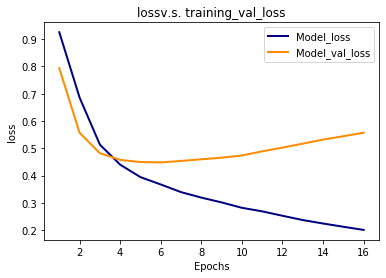

acc val_acc


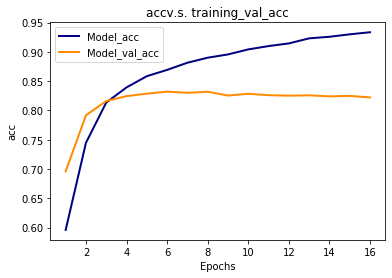

              precision    recall  f1-score   support

           0       0.90      0.78      0.84       857
           1       0.82      0.83      0.83      1112
           2       0.80      0.78      0.79       780

   micro avg       0.84      0.80      0.82      2749
   macro avg       0.84      0.80      0.82      2749
weighted avg       0.84      0.80      0.82      2749
 samples avg       0.80      0.80      0.80      2749

2749/2749 - 0s - loss: 0.4619 - acc: 0.8214
acc: 82.14%






C:\Users\Administrator\Anaconda3\envs\py810\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
BestModel_Name = file_name+ 'Best_GS'

############# Set hyper parameters
FILTER_SIZES=[2,3,4,5,6]
NUM_FILTERS=16
EMBEDDING_DIM = 200
BATCH_SIZE=64
NUM_EPOCHES=20 # patience=20
# CBOW_W2V = processor.w2v_pretrain(EMBEDDING_DIM) # 需要train, 比较慢
# Glove_W2V = processor.load_glove_w2v(EMBEDDING_DIM) # 需要下载, 比较慢
OPT = optimizers.Adam(lr=1e-4)
trainable_switch=True

model = model_Create(FS=FILTER_SIZES, NF=NUM_FILTERS, MDL=MAX_DOC_LEN,MNW=MAX_NB_WORDS, EMB=EMBEDDING_DIM, PWV = None, trainable_switch=trainable_switch, optimizer=OPT, patience=10  )
model_best_1_pred = train_model(model, x_train, y_train, x_test, y_test, BATCH_SIZE, NUM_EPOCHES, BestModel_Name=BestModel_Name)


Train on 19789 samples, validate on 4948 samples
Epoch 1/20
19789/19789 - 8s - loss: 0.9703 - acc: 0.5661 - val_loss: 0.8481 - val_acc: 0.6582
Epoch 2/20
19789/19789 - 8s - loss: 0.7763 - acc: 0.6945 - val_loss: 0.6538 - val_acc: 0.7561
Epoch 3/20
19789/19789 - 8s - loss: 0.5834 - acc: 0.7869 - val_loss: 0.5165 - val_acc: 0.8030
Epoch 4/20
19789/19789 - 7s - loss: 0.4761 - acc: 0.8245 - val_loss: 0.4744 - val_acc: 0.8131
Epoch 5/20
19789/19789 - 7s - loss: 0.4253 - acc: 0.8455 - val_loss: 0.4549 - val_acc: 0.8209
Epoch 6/20
19789/19789 - 7s - loss: 0.3911 - acc: 0.8580 - val_loss: 0.4479 - val_acc: 0.8262
Epoch 7/20
19789/19789 - 7s - loss: 0.3658 - acc: 0.8673 - val_loss: 0.4494 - val_acc: 0.8268
Epoch 8/20
19789/19789 - 7s - loss: 0.3417 - acc: 0.8787 - val_loss: 0.4488 - val_acc: 0.8272
Epoch 9/20
19789/19789 - 7s - loss: 0.3225 - acc: 0.8857 - val_loss: 0.4511 - val_acc: 0.8306
Epoch 10/20
19789/19789 - 6s - loss: 0.3081 - acc: 0.8923 - val_loss: 0.4558 - val_acc: 0.8310
Epoch 11/2

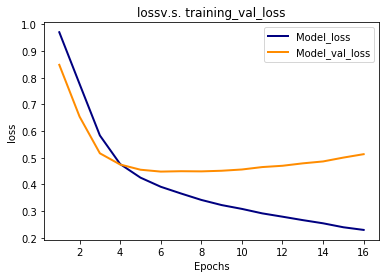

acc val_acc


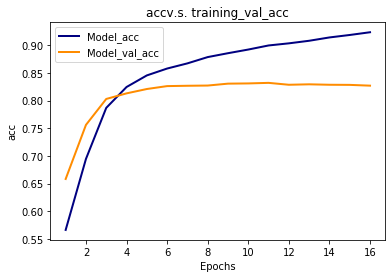

C:\Users\Administrator\Anaconda3\envs\py810\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.90      0.78      0.83       857
           1       0.82      0.85      0.83      1112
           2       0.82      0.76      0.79       780

   micro avg       0.84      0.80      0.82      2749
   macro avg       0.84      0.79      0.82      2749
weighted avg       0.84      0.80      0.82      2749
 samples avg       0.80      0.80      0.80      2749

2749/2749 - 0s - loss: 0.4646 - acc: 0.8232
acc: 82.32%






In [28]:
BestModel_Name =  file_name + 'Best_GS_2'

############# Set hyper parameters
FILTER_SIZES= (2, 3, 4, 5)
NUM_FILTERS=32
EMBEDDING_DIM = 200
BATCH_SIZE=64
NUM_EPOCHES=20 # patience=20
# CBOW_W2V = processor.w2v_pretrain(EMBEDDING_DIM) # 需要train, 比较慢
# Glove_W2V = processor.load_glove_w2v(EMBEDDING_DIM) # 需要下载, 比较慢
OPT = optimizers.Adam(lr=1e-4)
trainable_switch=True


model = model_Create(FS=FILTER_SIZES, NF=NUM_FILTERS, MDL=MAX_DOC_LEN,MNW=MAX_NB_WORDS, EMB=EMBEDDING_DIM, PWV = None, trainable_switch=trainable_switch, optimizer=OPT )
model_best_2_pred = train_model(model, x_train, y_train, x_test, y_test, BATCH_SIZE, NUM_EPOCHES, BestModel_Name=BestModel_Name)
